In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import nltk 
from nltk.corpus import stopwords 
from tqdm import tqdm
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import joblib

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
pkl_dir = r"C:\Users\admin\OneDrive\Desktop\ML\data\News.pkl"
csv_dir = r"C:\Users\admin\OneDrive\Desktop\ML\News.csv"

In [5]:
# Check if file is exist
def check_file_exist(file_path) -> bool:
    import os
    return os.path.exists(file_path)

# 1. Load and preprocess the data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, index_col=0)
    data = data.drop(["title", "subject", "date"], axis=1)
    
    # Shuffling data
    data = data.sample(frac=1).reset_index(drop=True)
    return data

# 2. Preprocess the text data
def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower() for token in str(sentence).split() 
      if token not in stopwords.words('english')))
    return preprocessed_text

# 3. Visualize word cloud
def visualize_word_cloud(data, label, title):
    text = ' '.join(word for word in data['text'][data['class'] == label].astype(str))
    wordCloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110, collocations=False)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordCloud.generate(text), interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 4. Get top n words in corpus
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

# 5. Train and evaluate model
def train_and_evaluate_model(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, model.predict(x_test))
    return train_acc, test_acc

# 6. Plot confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    cm = metrics.confusion_matrix(y_test, model.predict(x_test))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    cm_display.plot()
    plt.show()


In [ ]:
# # Tiền xử lý dữ liệu và lưu vào file pkl
# data = load_and_preprocess_data(csv_dir)
# data['text'] = preprocess_text(data['text'].values)
# print("Đã tiền xử lý dữ liệu văn bản xong !")
# joblib.dump(data, pkl_dir)
# print("Đã lưu dữ liệu thành công !")

In [6]:
# Load dữ liệu từ file pkl
data = joblib.load(pkl_dir)

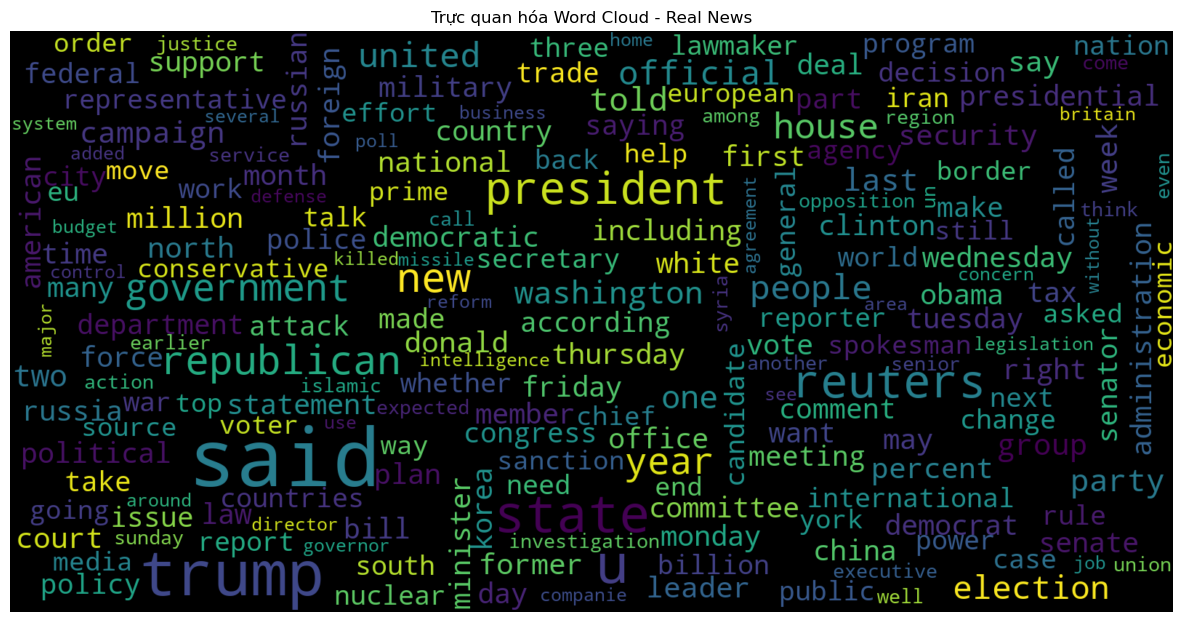

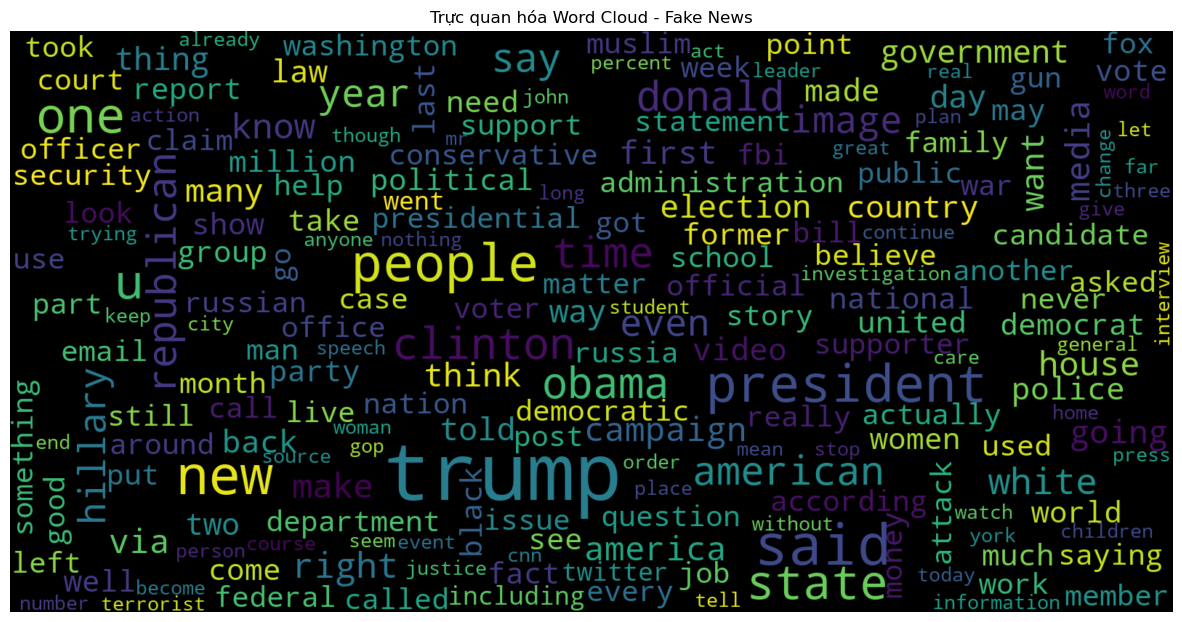

In [7]:
# Trực quan hóa dữ liệu
visualize_word_cloud(data, 1, "Trực quan hóa Word Cloud - Real News")
visualize_word_cloud(data, 0, "Trực quan hóa Word Cloud - Fake News")

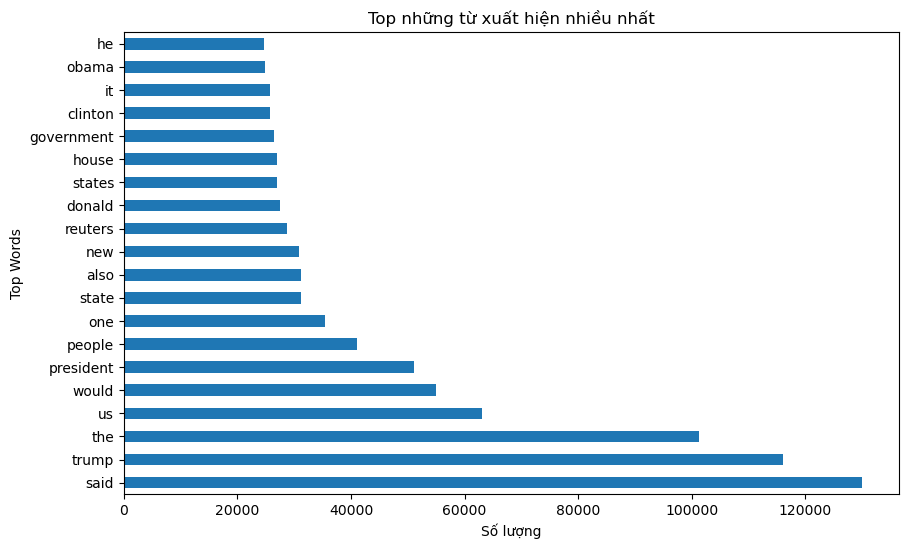

In [8]:
# Top 20 từ phổ biến trong dữ liệu
common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Word', 'Count'])
df1.groupby('Word').sum()['Count'].sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.title("Top những từ xuất hiện nhiều nhất")
plt.ylabel("Top Words")
plt.xlabel("Số lượng")
plt.show()

In [9]:
# Chia tập dữ liệu thành 75% train và 25% test và chuyển dữ liệu văn bản thành dạng vector
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.25)
print("Đã chia dữ liệu xong ! 75% train và 25% test")
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test  = vectorizer.transform(x_test)

Đã chia dữ liệu xong ! 75% train và 25% test


In [10]:
# Huấn luyện model với mô hình Logistic Regression
log_model = LogisticRegression()
log_reg_train_acc, log_reg_test_acc = train_and_evaluate_model(x_train, y_train, x_test, y_test,log_model)
log_reg_test_acc = round(log_reg_test_acc * 100, 4)
log_reg_train_acc = round(log_reg_train_acc * 100, 4)
print(f"=== Logistic Regression ===\nĐộ chính xác của quá trình train: {log_reg_train_acc}%\nĐộ chính xác của quá trình test: {log_reg_test_acc}%")

=== Logistic Regression ===
Độ chính xác của quá trình train: 99.3915%
Độ chính xác của quá trình test: 98.7801%


=== Decision Tree ===
Độ chính xác của quá trình train: 99.997%
Độ chính xác của quá trình test: 99.528%


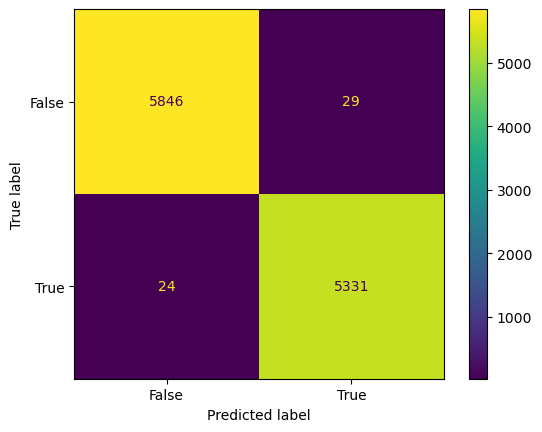

In [11]:
# Huấn luyện model với mô hình Decision Tree
decision_model = DecisionTreeClassifier()
dt_train_acc, dt_test_acc = train_and_evaluate_model(x_train, y_train, x_test, y_test, decision_model)
dt_test_acc = round(dt_test_acc * 100, 4)
dt_train_acc = round(dt_train_acc * 100, 4)
print(f"=== Decision Tree ===\nĐộ chính xác của quá trình train: {dt_train_acc}%\nĐộ chính xác của quá trình test: {dt_test_acc}%")
plot_confusion_matrix(decision_model, x_test, y_test)

In [12]:
# Test thử mô hình đã huấn luyện
test_data = input("Nhập dữ liệu cần kiểm tra: ")
test_data = preprocess_text([test_data])
test_data = vectorizer.transform(test_data)
result = decision_model.predict(test_data)
if result[0] == 1:
    print("Dữ liệu này là tin thật !")
else:
    print("Dữ liệu này là tin giả !")

100%|██████████| 1/1 [00:00<00:00, 24.49it/s]

Dữ liệu này là tin thật !
